# GPU STREAM Variant Experiments with MI250 (and A100) nodes on JURECA DC

Investigation by [Andreas Herten](https://www.fz-juelich.de/profile/herten_a) for [X-Dev Blog](https://x-dev.pages.jsc.fz-juelich.de/) in July 2022, see https://go.fzj.de/jsc-amdgpu-eval.

Imports and config

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, EngFormatter, LogFormatter, LogFormatterExponent, FormatStrFormatter, ScalarFormatter
sns.set()
%matplotlib inline
formatter = EngFormatter(sep="\N{THIN SPACE}", unit='B/s')
plt.rcParams.update({'text.usetex': False})
plt.rcParams.update({'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']})

## STREAM Scan

Bandwidth for different message sizes


In [2]:
name_files = {
    'scan': {
        'amd': 'stream-scan-10657249-jrc0850.csv',
        'nvidia': 'stream-scan-10657443-jrc0437.csv'
    }
}

Read data and massage it

In [3]:
df_scan = {}
for vendor, filename in name_files['scan'].items():
    _df = pd.read_csv(filename)
    _df['Exponent NElement'] = _df.index
    _df['Data Size / Byte'] = _df['Exponent NElement']  ## Initialize, to be able to use `.rpow()`
    _df['Data Size / Byte'] = _df['Data Size / Byte'].rpow(2) * 2**3  # double-precision
    _df.set_index('Data Size / Byte', inplace=True)
    df_scan[vendor] = _df

In [4]:
df_scan_max = {}
df_scan_max_triad = {}
for vendor, _df in df_scan.items():
    df_scan_max[vendor] = _df.loc[:, _df.columns.str.contains("Max")]
    df_scan_max_triad[vendor] = df_scan_max[vendor].loc[:, df_scan_max[vendor].columns.str.contains("Triad")]

### AMD MI250

In [19]:
3200 * 1000 * 1000  * 8192 / 8 

3276800000000.0

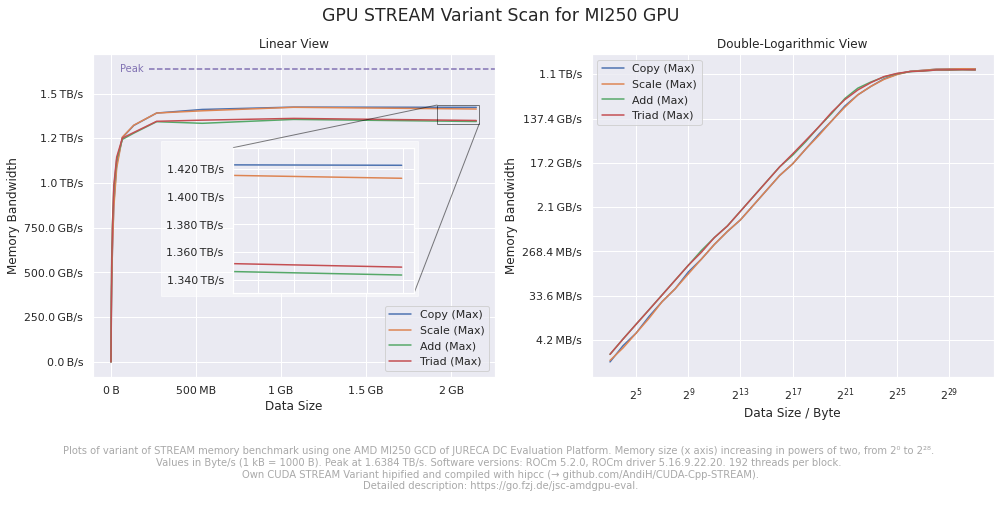

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
plot_scan_limits = {'lin': {}, 'log': {}}
for ax, logplot in zip(axs, [False, True]):
    df_scan_max['amd'].columns = df_scan_max['amd'].columns.str.rstrip(' / GiB/s')
    ax=(df_scan_max['amd']*1024*1024*1024).plot(ax=ax)
    if not logplot:
        ax.xaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B"))
        ax.set_xlabel("Data Size")
        rect = patches.Rectangle((0.17,0.25), 0.64, 0.48, linewidth=1, facecolor='white', alpha=0.5, transform=ax.transAxes)
        ax.add_patch(rect)
        ax_ins = ax.inset_axes([0.35, 0.26, 0.45, 0.45])
        ax_ins=(df_scan_max['amd']*1024*1024*1024).plot(ax=ax_ins, legend=False)
        ax_ins.set_xlim(0.85*ax.get_xlim()[1], 0.96*ax.get_xlim()[1])
        ax_ins.set_ylim(0.89*ax.get_ylim()[1], 0.96*ax.get_ylim()[1])
        ax_ins.set_xticklabels([])
        ax_ins.set_xlabel(None)
        ax_ins.yaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B/s", places=3))
        ax.indicate_inset_zoom(ax_ins, edgecolor="black")
        ax.set_title(f'Linear View')
        plot_scan_limits['lin']['x'] = ax.get_xlim()
        ax.hlines(3200 * 1000 * 1000  * 8192 / 8 / 2, 0.1*ax.get_xlim()[1], ax.get_xlim()[1], linestyles=['dashed'], colors='C4')
        ax.annotate("Peak", 
                    (0.08*ax.get_xlim()[1], 3200 * 1000 * 1000  * 8192 / 8 / 2), 
                    xycoords='data', color='C4', 
                    horizontalalignment='right', verticalalignment='center'
                   )
        plot_scan_limits['lin']['y'] = ax.get_ylim()
        ax.set_xlim(plot_scan_limits['lin']['x'])
    if logplot:
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        plot_scan_limits['log']['x'] = ax.get_xlim()
        plot_scan_limits['log']['y'] = ax.get_ylim()
        ax.set_title(f'Double-Logarithmic View')
    ax.yaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B/s", places=1))
    ax.set_ylabel('Memory Bandwidth')
fig.suptitle("GPU STREAM Variant Scan for MI250 GPU", fontsize='xx-large')
disclaimer = """
Plots of variant of STREAM memory benchmark using one AMD MI250 GCD of JURECA DC Evaluation Platform. Memory size (x axis) increasing in powers of two, from 2⁰ to 2²⁸. 
Values in Byte/s (1 kB = 1000 B). Peak at 1.6384 TB/s. Software versions: ROCm 5.2.0, ROCm driver 5.16.9.22.20. 192 threads per block. 
Own CUDA STREAM Variant hipified and compiled with hipcc (→ github.com/AndiH/CUDA-Cpp-STREAM).
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_scan_amd_mi250.{ext}", dpi=300, bbox_inches='tight')

### NVIDIA A100

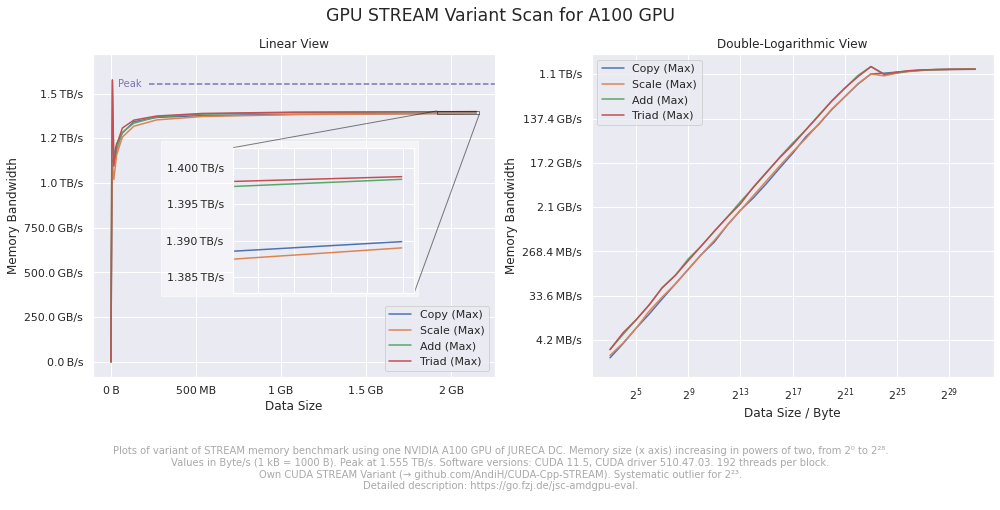

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
for ax, logplot in zip(axs, [False, True]):
    df_scan_max['nvidia'].columns = df_scan_max['nvidia'].columns.str.rstrip(' / GiB/s')
    ax=(df_scan_max['nvidia']*1024*1024*1024).plot(ax=ax)
    if not logplot:
        ax.xaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B"))
        ax.set_xlabel("Data Size")
        rect = patches.Rectangle((0.17,0.25), 0.64, 0.48, linewidth=1, facecolor='white', alpha=0.5, transform=ax.transAxes)
        ax.add_patch(rect)
        ax_ins = ax.inset_axes([0.35, 0.26, 0.45, 0.45])
        ax_ins=(df_scan_max['nvidia']*1024*1024*1024).plot(ax=ax_ins, legend=False)
        ax_ins.set_xlim(0.85*ax.get_xlim()[1], 0.96*ax.get_xlim()[1])
        ax_ins.set_ylim(0.836*ax.get_ylim()[1], 0.848*ax.get_ylim()[1])
        ax_ins.set_xticklabels([])
        ax_ins.set_xlabel(None)
        ax_ins.yaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B/s", places=3))
        ax.indicate_inset_zoom(ax_ins, edgecolor="black")
        ax.set_title(f'Linear View')
        ax.set_xlim(plot_scan_limits['lin']['x'])
        ax.set_ylim(plot_scan_limits['lin']['y'])
        ax.hlines(1555.2 * 1000 * 1000 * 1000, 0.1*ax.get_xlim()[1], ax.get_xlim()[1], linestyles=['dashed'], colors='C4')
        ax.annotate("Peak", 
                    (0.08*ax.get_xlim()[1], 1555. * 1000 * 1000  * 1000), 
                    xycoords='data', color='C4', 
                    horizontalalignment='right', verticalalignment='center'
                   )
    if logplot:
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        ax.set_title(f'Double-Logarithmic View')
        ax.set_xlim(plot_scan_limits['log']['x'])
        ax.set_ylim(plot_scan_limits['log']['y'])
    ax.yaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B/s", places=1))
    ax.set_ylabel('Memory Bandwidth')
fig.suptitle("GPU STREAM Variant Scan for A100 GPU", fontsize='xx-large')
disclaimer = """
Plots of variant of STREAM memory benchmark using one NVIDIA A100 GPU of JURECA DC. Memory size (x axis) increasing in powers of two, from 2⁰ to 2²⁸.
Values in Byte/s (1 kB = 1000 B). Peak at 1.555 TB/s. Software versions: CUDA 11.5, CUDA driver 510.47.03. 192 threads per block.
Own CUDA STREAM Variant (→ github.com/AndiH/CUDA-Cpp-STREAM). Systematic outlier for 2²³.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_scan_nvidia_a100.{ext}", dpi=300, bbox_inches='tight')

### MI250 vs A100

Comparing max Triad bandwidth for MI250 vs. A100

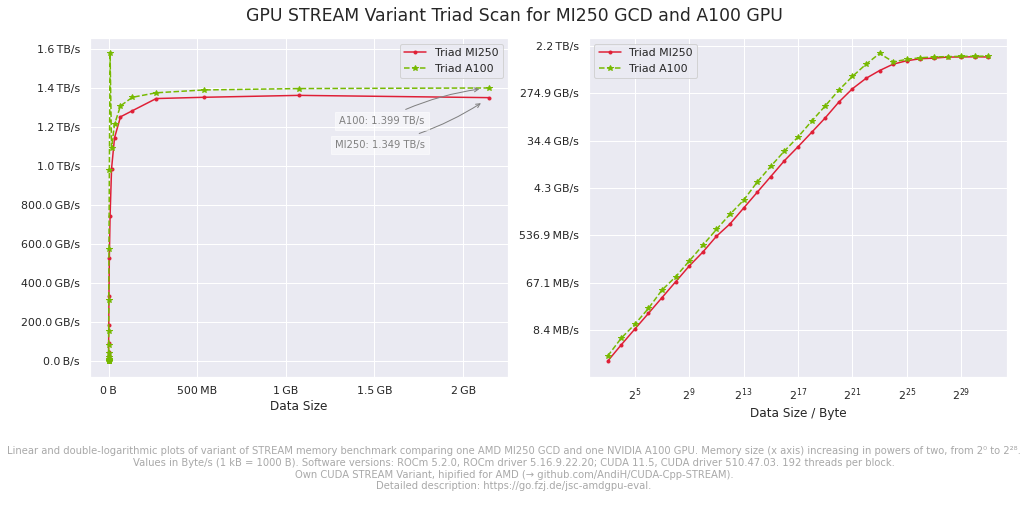

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
color_amd = (223/255,31/255,54/255)
color_nvidia = (118/255,185/255,0)
for ax, logplot in zip(axs, [False, True]):
    ax=(df_scan_max_triad['amd'].rename(columns={'Triad (Max) / GiB/s': 'Triad MI250'})*1024*1024*1024).plot(ax=ax, marker=".", color=color_amd)
    ax=(df_scan_max_triad['nvidia'].rename(columns={'Triad (Max) / GiB/s': 'Triad A100'})*1024*1024*1024).plot(ax=ax, linestyle="dashed", marker="*", color=color_nvidia)
    if logplot:
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
    if logplot == False:
        ax.xaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B"))
        ax.set_xlabel("Data Size")
        ax.annotate('MI250: {bw} TB/s'.format(bw=round((df_scan_max_triad['amd']*1024*1024*1024/1000/1000/1000/1000).iloc[-1].tolist()[0], 3)), 
                    (df_scan_max_triad['amd']*1024*1024*1024).reset_index().iloc[-1].tolist(),
                    xycoords='data', xytext=(0.8, 0.7), textcoords='axes fraction',
                    bbox=dict(facecolor='white', alpha=0.5),
                    arrowprops=dict(arrowstyle="->", color='gray', connectionstyle='arc3,rad=0.1',shrinkA=5, shrinkB=10), color="gray", horizontalalignment='right', verticalalignment='top',
            )
        ax.annotate('A100: {bw} TB/s'.format(bw=round((df_scan_max_triad['nvidia']*1024*1024*1024/1000/1000/1000/1000).iloc[-1].tolist()[0], 3)), 
                    (df_scan_max_triad['nvidia']*1024*1024*1024).reset_index().iloc[-1].tolist(),
                    xycoords='data', xytext=(0.8, 0.77), textcoords='axes fraction',
                    bbox=dict(facecolor='white', alpha=0.5),
                    arrowprops=dict(arrowstyle="->", color='gray', connectionstyle='arc3,rad=-0.1',shrinkA=5, shrinkB=10), color="gray", horizontalalignment='right', verticalalignment='top',
            )
    ax.yaxis.set_major_formatter(EngFormatter(sep="\N{THIN SPACE}", unit="B/s", places=1))
fig.suptitle("GPU STREAM Variant Triad Scan for MI250 GCD and A100 GPU", fontsize='xx-large')
disclaimer = """
Linear and double-logarithmic plots of variant of STREAM memory benchmark comparing one AMD MI250 GCD and one NVIDIA A100 GPU. Memory size (x axis) increasing in powers of two, from 2⁰ to 2²⁸.
Values in Byte/s (1 kB = 1000 B). Software versions: ROCm 5.2.0, ROCm driver 5.16.9.22.20; CUDA 11.5, CUDA driver 510.47.03. 192 threads per block.
Own CUDA STREAM Variant, hipified for AMD (→ github.com/AndiH/CUDA-Cpp-STREAM).
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_scan_compare_mi250_a100.{ext}", dpi=300, bbox_inches='tight')

## STREAM Overview: Threads vs. Data Size
### MI250

In [8]:
df_stream = {}
df_stream['amd'] = pd.read_csv("stream-10607580-jrc0850.csv")
df_stream['amd']["Data Size / MiB"] = df_stream['amd'] ["Exponent"].rpow(2) * 8 / 1024 / 1024
df_stream['amd'] = df_stream['amd'].set_index(["Data Size / MiB", "Threads per Block"])

#### Absolute

In [23]:
_df_pivot.sort_index(ascending=False)

Data Size / MiB       512.0      2048.0     8192.0
Threads per Block                                 
1024               1194.0512  1190.2111  1135.4497
512                1241.6530  1241.9594  1187.6554
256                1262.5840  1260.4971  1210.5210
128                1258.5429  1251.0974  1191.8881

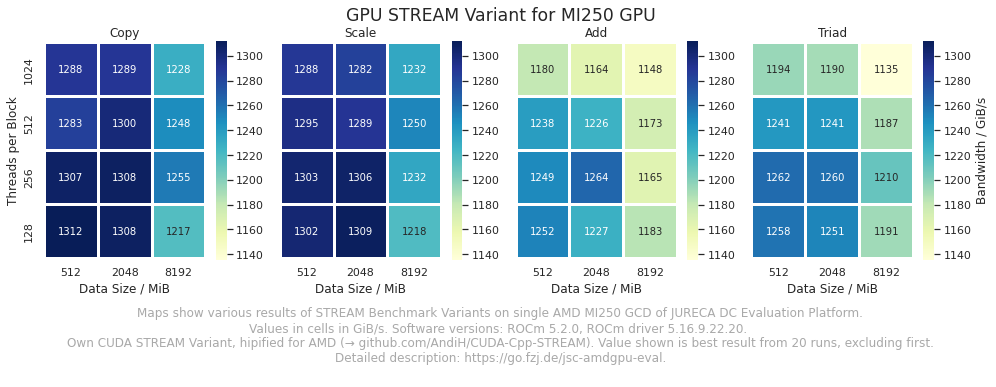

In [24]:
cols = ['Copy (Max) / GiB/s', 'Scale (Max) / GiB/s', 'Add (Max) / GiB/s', 'Triad (Max) / GiB/s']
fig, axs = plt.subplots(ncols=4, figsize=(14,4), sharey=True)
for i, (ax, col) in enumerate(zip(axs, cols)):
    _df_pivot = df_stream['amd'].pivot_table(index="Threads per Block", values=col, columns="Data Size / MiB").sort_index(ascending=False)
    sns.heatmap(
        _df_pivot, 
        cmap="YlGnBu", 
        linewidths=3, 
        square=True, 
        fmt=".0f", 
        cbar_kws={'label': 'Bandwidth / GiB/s'},
        annot=_df_pivot.astype(int),
        vmin=df_stream['amd'][cols].min().min(),
        vmax=df_stream['amd'][cols].max().max(),
        ax=ax
    )
    ax.set_title(f'{col.split(" ")[0]}')
    #ax.set_xlabel(2**int(ax.get_xlabel()))
    if i > 0:
        ax.set_ylabel(None)
    if i < 3:
        fig.get_axes()[-1].set_ylabel(None)
    ax.set_xticklabels(label.get_text()[:-2] for label in ax.get_xticklabels())
    fig.suptitle("GPU STREAM Variant for MI250 GPU", fontsize='xx-large')
disclaimer = """
Maps show various results of STREAM Benchmark Variants on single AMD MI250 GCD of JURECA DC Evaluation Platform.
Values in cells in GiB/s. Software versions: ROCm 5.2.0, ROCm driver 5.16.9.22.20. 
Own CUDA STREAM Variant, hipified for AMD (→ github.com/AndiH/CUDA-Cpp-STREAM). Value shown is best result from 20 runs, excluding first.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top", fontsize="large")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_datavsthreads_mi250-abs.{ext}", dpi=300, bbox_inches='tight')

#### Relative

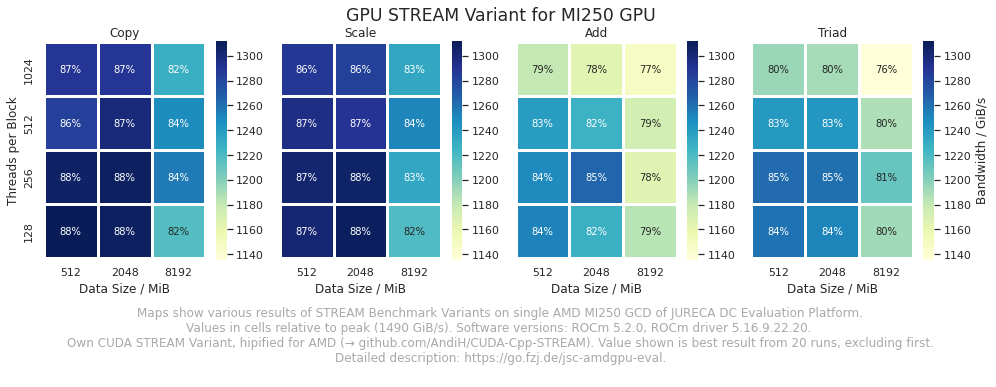

In [25]:
cols = ['Copy (Max) / GiB/s', 'Scale (Max) / GiB/s', 'Add (Max) / GiB/s', 'Triad (Max) / GiB/s']
fig, axs = plt.subplots(ncols=4, figsize=(14,4), sharey=True)
for i, (ax, col) in enumerate(zip(axs, cols)):
    _df_pivot = df_stream['amd'].pivot_table(index="Threads per Block", values=col, columns="Data Size / MiB").sort_index(ascending=False)
    sns.heatmap(
        _df_pivot, 
        cmap="YlGnBu", 
        linewidths=3,
        square=True, 
        fmt=",.0%", 
        cbar_kws={'label': 'Bandwidth / GiB/s'},
        annot=(_df_pivot / (3200 * 1000 * 1000 * 1000 / 1024 / 1024 / 1024 / 1024  * 8192 / 8 / 2)),
        vmin=df_stream['amd'][cols].min().min(),
        vmax=df_stream['amd'][cols].max().max(),
        ax=ax
    )
    ax.set_title(f'{col.split(" ")[0]}')
    #ax.set_xlabel(2**int(ax.get_xlabel()))
    if i > 0:
        ax.set_ylabel(None)
    if i < 3:
        fig.get_axes()[-1].set_ylabel(None)
    ax.set_xticklabels(label.get_text()[:-2] for label in ax.get_xticklabels())
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.suptitle("GPU STREAM Variant for MI250 GPU", fontsize='xx-large')
disclaimer = """
Maps show various results of STREAM Benchmark Variants on single AMD MI250 GCD of JURECA DC Evaluation Platform.
Values in cells relative to peak (1490 GiB/s). Software versions: ROCm 5.2.0, ROCm driver 5.16.9.22.20. 
Own CUDA STREAM Variant, hipified for AMD (→ github.com/AndiH/CUDA-Cpp-STREAM). Value shown is best result from 20 runs, excluding first.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top", fontsize="large")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_datavsthreads_mi250-rel.{ext}", dpi=300, bbox_inches='tight')

### A100

In [12]:
df_stream['nvidia'] = pd.read_csv("stream-10608023-jrc0437--nvidia.csv")
df_stream['nvidia']["Data Size / MiB"] = df_stream['nvidia']["Exponent"].rpow(2) * 8/ 1024 / 1024
df_stream['nvidia'] = df_stream['nvidia'].set_index(["Data Size / MiB", "Threads per Block"])

#### Absolute

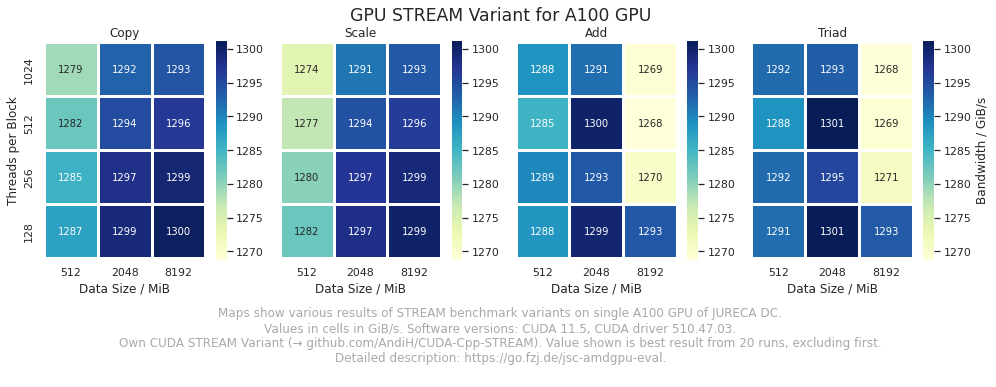

In [26]:
cols = ['Copy (Max) / GiB/s', 'Scale (Max) / GiB/s', 'Add (Max) / GiB/s', 'Triad (Max) / GiB/s']
fig, axs = plt.subplots(ncols=4, figsize=(14,4), sharey=True)
for i, (ax, col) in enumerate(zip(axs, cols)):
    _df_pivot_nv = df_stream['nvidia'].pivot_table(index="Threads per Block", values=col, columns="Data Size / MiB").sort_index(ascending=False)
    sns.heatmap(
        _df_pivot_nv, 
        cmap="YlGnBu", 
        linewidths=3, 
        #norm=LogNorm(df_stream.min().min(), df_stream.max().max()), 
        square=True, 
        fmt=".0f", 
        cbar_kws={'label': 'Bandwidth / GiB/s'},
        annot=_df_pivot_nv.astype(int),
        #mask=mask,
        vmin=df_stream['nvidia'][cols].min().min(),
        vmax=df_stream['nvidia'][cols].max().max(),
        ax=ax
    )
    ax.set_title(f'{col.split(" ")[0]}')
    if i > 0:
        ax.set_ylabel(None)
    if i < 3:
        fig.get_axes()[-1].set_ylabel(None)
    ax.set_xticklabels(label.get_text()[:-2] for label in ax.get_xticklabels())
    fig.suptitle("GPU STREAM Variant for A100 GPU", fontsize='xx-large')
disclaimer = """
Maps show various results of STREAM benchmark variants on single A100 GPU of JURECA DC.
Values in cells in GiB/s. Software versions: CUDA 11.5, CUDA driver 510.47.03.
Own CUDA STREAM Variant (→ github.com/AndiH/CUDA-Cpp-STREAM). Value shown is best result from 20 runs, excluding first.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top", fontsize="large")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_datavsthreads_a100-abs.{ext}", dpi=300, bbox_inches='tight')

#### Relative

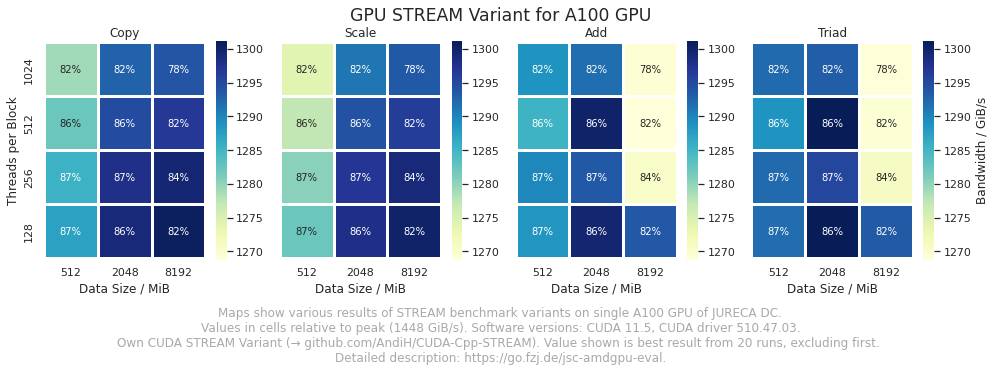

In [27]:
cols = ['Copy (Max) / GiB/s', 'Scale (Max) / GiB/s', 'Add (Max) / GiB/s', 'Triad (Max) / GiB/s']
fig, axs = plt.subplots(ncols=4, figsize=(14,4), sharey=True)
for i, (ax, col) in enumerate(zip(axs, cols)):
    _df_pivot_nv = df_stream['nvidia'].pivot_table(index="Threads per Block", values=col, columns="Data Size / MiB").sort_index(ascending=False)
    sns.heatmap(
        _df_pivot_nv, 
        cmap="YlGnBu", 
        linewidths=3, 
        #norm=LogNorm(df_stream.min().min(), df_stream.max().max()), 
        square=True,
        fmt=",.0%", 
        cbar_kws={'label': 'Bandwidth / GiB/s'},
        annot=_df_pivot / (1555.2 * 1000 * 1000 * 1000 / 1024 / 1024 / 1024),
        #mask=mask,
        vmin=df_stream['nvidia'][cols].min().min(),
        vmax=df_stream['nvidia'][cols].max().max(),
        ax=ax
    )
    ax.set_title(f'{col.split(" ")[0]}')
    if i > 0:
        ax.set_ylabel(None)
    if i < 3:
        fig.get_axes()[-1].set_ylabel(None)
    ax.set_xticklabels(label.get_text()[:-2] for label in ax.get_xticklabels())
    fig.suptitle("GPU STREAM Variant for A100 GPU", fontsize='xx-large')
disclaimer = """
Maps show various results of STREAM benchmark variants on single A100 GPU of JURECA DC.
Values in cells relative to peak (1448 GiB/s). Software versions: CUDA 11.5, CUDA driver 510.47.03.
Own CUDA STREAM Variant (→ github.com/AndiH/CUDA-Cpp-STREAM). Value shown is best result from 20 runs, excluding first. 
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top", fontsize="large")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"stream_datavsthreads_a100-rel.{ext}", dpi=300, bbox_inches='tight')

# Raw Data

In the following, the raw data of the analysis here is shown. The data is read from the CSV file and presented in base64-encoding. To write to a file (or a `StringIO` object directly), just invert the procedure and copy the string and b64decode it.

In [15]:
from pathlib import Path
import base64

In [17]:
for host, sizes in name_files.items():
    for size, file in sizes.items():
        _file_content = Path(file).read_text()
        b64_content = base64.b64encode(_file_content.encode('utf-8'))
        print(f'df[{host}][{size}]: {b64_content}')

df[scan][amd]: b'Q29weSAoTWF4KSAvIEdpQi9zLENvcHkgKE1pbikgLyBHaUIvcyxDb3B5IChBdmcpIC8gR2lCL3MsU2NhbGUgKE1heCkgLyBHaUIvcyxTY2FsZSAoTWluKSAvIEdpQi9zLFNjYWxlIChBdmcpIC8gR2lCL3MsQWRkIChNYXgpIC8gR2lCL3MsQWRkIChNaW4pIC8gR2lCL3MsQWRkIChBdmcpIC8gR2lCL3MsVHJpYWQgKE1heCkgLyBHaUIvcyxUcmlhZCAoTWluKSAvIEdpQi9zLFRyaWFkIChBdmcpIC8gR2lCL3MKMC4wMDE0LDAuMDAxMiwwLjAwMTMsMC4wMDE1LDAuMDAxMiwwLjAwMTMsMC4wMDIwLDAuMDAxNiwwLjAwMTksMC4wMDIwLDAuMDAxOCwwLjAwMTkKMC4wMDMwLDAuMDAyMywwLjAwMjYsMC4wMDI3LDAuMDAyNSwwLjAwMjYsMC4wMDQxLDAuMDAzNywwLjAwMzksMC4wMDQxLDAuMDAzNywwLjAwMzgKMC4wMDU0LDAuMDA0NSwwLjAwNTIsMC4wMDU0LDAuMDA0OSwwLjAwNTIsMC4wMDgyLDAuMDA3NCwwLjAwNzcsMC4wMDgyLDAuMDA2OSwwLjAwNzcKMC4wMTE5LDAuMDA5MSwwLjAxMDcsMC4wMTA5LDAuMDA5OCwwLjAxMDQsMC4wMTYzLDAuMDEzNiwwLjAxNTMsMC4wMTYzLDAuMDE0NywwLjAxNTEKMC4wMjM4LDAuMDE4MiwwLjAyMDcsMC4wMjM4LDAuMDIwMCwwLjAyMTIsMC4wMzI2LDAuMDI3MywwLjAzMDYsMC4wMzI2LDAuMDI3MywwLjAzMDQKMC4wNDM1LDAuMDM5MiwwLjA0MjAsMC4wNDM1LDAuMDI4MiwwLjA0MDMsMC4wNjUyLDAuMDU0NSwwLjA2MDEsMC4wNjUyLDAuMDU1NiwwLjA2MTgKMC4